In [1]:
#!/usr/bin/env python
# coding: utf-8

# Author: Matthew Portman
# Date: 11/11/21

# # GW_transient_compare
# ### This now does many things but all are related to handling Gravitational Wave (GW) localization maps and DESI observations.
# ### Most generally, this finds those observations in the area of a specified confidence interval (CI) of the GW map.
# ### It also does the following:

# 1. Finds *not-previously-observed* ALERCE alerts in the area and creates a ToO ledger for those.
# 2. Identifies Bright and Dark targets in the CI contour.
# 3. Compares previous observations with dr9 targets in the CI contour to find the dr9 targets not already observed. Can perform this comparison by matching the targetids or by matching the RA's and DEC's which we feel is slightly more robust.
# 4. A bit of plotting but it takes awhile to produce a proper cartesian map, be forewarned.

# Importing all functions here
from GW_transient_compare_functions import *
"""
import sys
import os
user_home = os.environ['HOME']

# For importing useful functions
sys.path.append('/global/homes/p/portmanm/timedomain/')

_ = [sys.path.append(user_home + '/desi/' + x + '/py/') for x in os.listdir('/global/homes/p/portmanm/desi/')]
#sys.path.append('/global/homes/p/portmanm/desi/desiutil/py/')

from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique, setdiff
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle
from astropy.time import Time

import requests
from alerce.core import Alerce
from alerce.exceptions import APIError

from gw_skymap import plot_mollmap, compute_quantiles, compute_contours #, plot_cartmap
from desitarget import io, cuts
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import numpy as np

from copy import deepcopy
from glob import glob
import argparse
import logging # to disable output when reading in FITS info

import sqlite3

import pickle
"""

"\nimport sys\nimport os\nuser_home = os.environ['HOME']\n\n# For importing useful functions\nsys.path.append('/global/homes/p/portmanm/timedomain/')\n\n_ = [sys.path.append(user_home + '/desi/' + x + '/py/') for x in os.listdir('/global/homes/p/portmanm/desi/')]\n#sys.path.append('/global/homes/p/portmanm/desi/desiutil/py/')\n\nfrom astropy.io import fits\nfrom astropy.table import Table, Column, join, hstack, vstack, unique, setdiff\nfrom astropy import units as u\nfrom astropy.coordinates import SkyCoord, match_coordinates_sky, Angle\nfrom astropy.time import Time\n\nimport requests\nfrom alerce.core import Alerce\nfrom alerce.exceptions import APIError\n\nfrom gw_skymap import plot_mollmap, compute_quantiles, compute_contours #, plot_cartmap\nfrom desitarget import io, cuts\nfrom desispec.io import read_spectra, write_spectra\nfrom desispec.spectra import Spectra\n\nimport matplotlib.pyplot as plt\nimport healpy as hp\nimport pandas as pd\nimport numpy as np\n\nfrom copy import dee

In [2]:
# *************************************************************************
#
# SETTING SOME DEFAULT VARIABLES AND PREPARING
#
# *************************************************************************

global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'

# Hardcoding this for now until I can get the environment set up right
global exposure_path
exposure_path = "/global/cfs/cdirs/desi/spectro/redux" #os.environ["DESI_SPECTRO_REDUX"]

global color_band
color_band = "r"

global today
today = Time.now()

# TODO: Suppress hp warnings

In [3]:
# *************************************************************************
#
# SETTING UP AND GRABBING COMMAND LINE ARGS
#
# *************************************************************************

help_text = f"""{sys.argv[0]} handles and compares Gravitational Wave (GW)
localization maps to DESI observations. Most generally, the code finds those
observations in the area of a user-specified confidence interval (CI) of the GW map."""

parser = argparse.ArgumentParser(description = help_text)
c_intervals = parser.add_mutually_exclusive_group()
d_modes = parser.add_mutually_exclusive_group()


parser.add_argument(dest     = 'gwfile', 
                    type     = str, 
                    help     = 'The input GW file')

# Not yet implemented, leaving out for now
# parser.add_argument(dest     = 'pointings',
#                     type     = int,
#                     help     = 'Specify number of pointings')

c_intervals.add_argument('--confidence_interval=90', '-CI90', 
                    dest      = 'CI_val',
                    action    = 'store_const', 
                    const     = 0.9,
                    help      = 'Specifying 90%% CI')

c_intervals.add_argument('--confidence_interval=95', '-CI95', 
                    dest      = 'CI_val',
                    action    = 'store_const', 
                    const     = 0.95,
                    help      = 'Specifying 95%% CI')

d_modes.add_argument('--disruptive', '-D', 
                    dest   = 'mode', 
                    action = 'store_const', # store_true
                    const  = 0, # of pointings... # TODO: can this be fed to MI?
                    help   = 'Enable disruptive mode.')

d_modes.add_argument('--non-disruptive', '-ND', 
                    dest   = 'mode', 
                    action = 'store',
                    #const  = 20, # of pointings
                    help   = 'Enable non-disruptive mode and specify number of pointings.')

#args = parser.parse_args() # Using vars(args) will call produce the args as a dict
#gwfile = args.gwfile
#num_pointings = args.pointings

#gwfile = "/global/homes/p/portmanm/gw_maps_testing/fits_flattened/0.fits.gz"
gwfile = "/global/homes/p/portmanm/GW190412_combined_skymap.fits.gz"
CI_val = 0.9
nd_mode = 0

# try:
#     CI_val = args.CI_val
# except:
#     CI_val = 0.9

# # if nd_mode evaluates to false, disruptive since = 0
# try:
#     nd_mode = int(args.mode)
# except:
#     nd_mode = 10

In [4]:
# *************************************************************************
#
# SETTING UP DIRECTORY STRUCTURE
#
# *************************************************************************

try:
    h = fits.open(gwfile)
except FileNotFoundError:
    print("Could not find the GW file. Please specify either a relative or full path to the file. Exiting.")
    sys.exit()

#h=fits.open('skymaps/GW190412_combined_skymap.fits.gz')
head = h[1].header

# Naming
filename = os.path.basename(gwfile)
file_basename = filename.split(".fits")[0]
try:
    gw_name = str(head['OBJECT'])
except:
    print("OBJECT not found in header. Proceeding using filename and today's date.")
    gw_name = file_basename + '_' + str(round(today.mjd))

original_dir = os.getcwd()
path_gwfile = os.path.abspath(gwfile)

# Checks if 'master' folder in home directory and moves there
master_dir = os.path.join(user_home, 'GW_events_followup')
if not os.path.isdir(master_dir):
    os.mkdir(master_dir)

event_dir = os.path.join(master_dir, gw_name)
if not os.path.isdir(event_dir):
    os.mkdir(event_dir)

# I still try to use absolute paths where possible so as not to leave anything to chance
# But some functions may need to specify paths and rather than passing it along all the time
# I'll just use the current directory
os.chdir(event_dir)

# Copies event file to current directory
os.popen('cp ' + path_gwfile + ' ./')
path_gwfile = os.path.abspath(os.path.join(event_dir, filename))

targetlists_path = os.path.join(event_dir, 'targetlists')
# Check if targetlists folder exists, if not make one
if not os.path.isdir(targetlists_path):
    os.mkdir(targetlists_path)


OBJECT not found in header. Proceeding using filename and today's date.


In [5]:
# *************************************************************************
#
# READING IN SKYMAP, GRABBING INFORMATION, AND CONVERTING TO PIXEL MAP
#
# *************************************************************************

# Read in GW file, grab its properties, and determine pixels in CI area
gw_mjd = head['MJD-OBS']
gw_properties = read_gwfile(gwfile)

gw_map = hp.read_map(gwfile, nest = gw_properties["nest"])

# Grab pixel locations for probabilities in x% CI
# prob_pixel_locs is written to return a list of n pixel maps
# corresponding to CI (for checking multiple CI maps at once), hence the [CI_val].
# This no longer applies but I'd like to keep the functionality in
pixmap, pix_area = prob_pixel_locs(gw_properties, percentile = [CI_val])
pixmap = pixmap[CI_val]
pix_area = pix_area[CI_val]

# Too much stuff! 
if pix_area > 100:
    raise(Exception(f"The {CI_val*100}% map is too large (it's not worth it!), quitting."))

# Converting skymap to pixelmap
ra_map, dec_map = hp.pix2ang(gw_properties["nside"], pixmap, nest = gw_properties["nest"], lonlat = True)


The 90.0% map is 18.9857 deg^2


In [6]:
# *************************************************************************
#
# DEGRADING PIXEL MAP TO CONSTRAIN PIXEL SEARCH SPACE
#
# *************************************************************************
# Finds Supernova (SN) and Active Galactic Nuclei (AGN) matches in ALERCE alert broker data and matches to x% probability angles from above
gw_degraded_properties = deepcopy(gw_properties)
gw_degraded_properties["nside"] = 32
print("Degrading...")

# By using power = -2, we keep the sum of the map invariant (per documentation)
degrade_map = hp.ud_grade(gw_map, nside_out = gw_degraded_properties["nside"], order_in = gw_properties["nest"], order_out = gw_properties["nest"], power = -2)

gw_degraded_properties["prob"] = degrade_map
pix_degraded, _ = prob_pixel_locs(gw_degraded_properties, percentile = [CI_val])

ra_degraded, dec_degraded = hp.pix2ang(gw_degraded_properties["nside"], pix_degraded[CI_val], nest = gw_degraded_properties["nest"], lonlat = True)
# print("Ra degraded, dec degraded")
# print(*zip(ra_degraded, dec_degraded), sep = "\n")


Degrading...
The 90.0% map is 26.8574 deg^2


In [7]:
# *************************************************************************
#
# NON-DISRUPTIVE MODE
#
# *************************************************************************    

# Use some sneaky Python-fu to determine number of pointings 
# i.e. nd_mode as non-zero for bool evaluation and as integer
if nd_mode:
    nd_tile_info = nondisruptive_mode(gw_properties, gw_degraded_properties, pixmap,
                                      num_pointings = nd_mode, CI_level = CI_val, 
                                      restrict = False, overlap = True)

    outfile_name = f'{gw_name}_ND_ToO_ledger.ecsv'
    outfile = os.path.join(targetlists_path, outfile_name)

    # First time writing
    ow = True

    print(f"Writing to {outfile_name} for ND mode.")
    for k,v in nd_tile_info.items():
        print(f"Writing {k}...")
        # We use every column but the last because I've introduced a new column
        # that isn't needed in the output
        write_too_ledger(outfile, v.to_pandas(), 
                         checker='MP/AP', overwrite=ow, verbose=False, tabformat='ND')

        # Guarantee append after first key
        ow = False

    print()
    fig_outfile = os.path.join(targetlists_path, f"{gw_name}_ND_tiles.png")

    # For testing code, please ignore.
    #plot_pointings(ra_map, dec_map, pointing_dict = nd_tile_info, savename = fig_outfile)
    #sys.exit()

In [8]:
# *************************************************************************
#
# GRABBING TRANSIENT ALERT MATCHES 'WITHIN' DEGRADED PIXEL MAP PIXELS
#
# *************************************************************************
# mean pixel spacing 1.8323 deg, approximating to 2 deg or 7200 arcseconds (radius)
# We expand this to 4 degrees to account for edge cases/diameter
# Also doing it this way allows for non-continuous CI contours

# As a reminder, we rely on their classifier to determine SN or AGN

rad = 4
days_forward = 30

alerts = access_alerts(order_by = 'firstmjd',
                           order_mode = 'ASC',
                           class_names = ['SN', 'AGN'],
                           firstmjd = gw_mjd,
                           days_forward = days_forward,
                           ra = ra_degraded,
                           dec = dec_degraded,
                           radius = rad
                           )

if alerts.empty:
    print("No transient alert matches (SN or AGN) found within 4 degrees of CI contour.")
    #print("... this is unlikely. Something probably went wrong with call to broker!")
    print(f"For mjd -- {gw_mjd:.2f}, RA, DEC dump...")
    print(*zip(ra_degraded,dec_degraded), sep = "\n")
    #print("Exiting.")
    # For testing, please ignore.
    # sys.exit()
    print("Continuing...")

else:
    alerts_sn = alerts.groupby(alerts.class_name).get_group("SN")
    alerts_agn = alerts.groupby(alerts.class_name).get_group("AGN")

    alerts_sn_ra = alerts_sn['meanra'].to_numpy()
    alerts_sn_dec = alerts_sn['meandec'].to_numpy()

    alerts_agn_ra = alerts_agn['meanra'].to_numpy()
    alerts_agn_dec = alerts_agn['meandec'].to_numpy()

    # print("Number of SN alerts:", alerts_sn_ra.size)
    # print("Number of AGN alerts:", alerts_agn_ra.size)


In [9]:
# *************************************************************************
#
# FIND TRANSIENT ALERTS IN PROBABILITY REGION
#
# *************************************************************************

if not alerts.empty:
    
    # Convert ALERCE data to pixel locations on GW map for ease of comparison (since CI pixel range is continuous, no fancy matching necessary)
    transient_pix_locs_sn = hp.ang2pix(gw_properties["nside"], alerts_sn_ra, alerts_sn_dec, lonlat = True, nest = gw_properties["nest"])
    transient_pix_locs_agn = hp.ang2pix(gw_properties["nside"], alerts_agn_ra, alerts_agn_dec, lonlat = True, nest = gw_properties["nest"])

    # Checks for matches in region 
    trans_in_prob_region_sn = np.isin(transient_pix_locs_sn, pixmap)
    trans_in_prob_region_agn = np.isin(transient_pix_locs_agn, pixmap)

    if np.any(trans_in_prob_region_sn) or np.any(trans_in_prob_region_agn):
        print(trans_in_prob_region_sn.sum(), "SN matches")
        print(trans_in_prob_region_agn.sum(), "AGN matches")

    alerce_sn_rows = alerts_sn.loc[trans_in_prob_region_sn, :].sort_values(by='firstmjd')
    alerce_agn_rows = alerts_agn.loc[trans_in_prob_region_agn, :].sort_values(by='firstmjd')


8 SN matches
53 AGN matches


In [10]:
# *************************************************************************
#
# PLOT TRANSIENT ALERTS IN CI CONTOUR
#
# *************************************************************************

if not alerts.empty:

    plt.scatter(ra_map, dec_map, alpha = 0.6)
    plt.scatter(alerce_agn_rows['meanra'], alerce_agn_rows['meandec'], label='AGN', s=4, alpha=0.7)
    plt.scatter(alerce_sn_rows['meanra'], alerce_sn_rows['meandec'], label='SN', alpha=0.8)
    plt.legend()
    plt.xlim(213,222)
    plt.ylim(33,40)
    plt.gca().invert_xaxis()

    plt.savefig(os.path.join(event_dir, "GW_DESI_Alerce.png"))
    plt.clf()
    #sys.exit()


<Figure size 432x288 with 0 Axes>

In [11]:
# *************************************************************************
#
# WRITE TRANSIENT ALERTS ToO LEDGER TO ECSV
#
# *************************************************************************
# ## Write ToO ledger to ecsv!

'''Checker is Matthew Portman/Antonella Palmese 
So if anything seems off... blame Antonella
.
.
.
if you dare.
'''

## Only add SNe for now. AGNs should pass redshift cut. Also, Try rejecting stars
    #write_too_ledger(user_home + '/testing_ToO-Alerce.ecsv', alerce_sn_rows, checker='MP/AP', overwrite=True, verbose=True, tabformat='ALERCE')


'Checker is Matthew Portman/Antonella Palmese \nSo if anything seems off... blame Antonella\n.\n.\n.\nif you dare.\n'

In [12]:
# *************************************************************************
# *************************************************************************
# *************************************************************************
#
#
# PART 2 - 
# MATCHING DESI OBSERVATIONS TO X% CI CONTOUR
# BUILDING DR9 TARGETLIST
#
#
# *************************************************************************
# *************************************************************************
# *************************************************************************

# ## Matching DESI observations to x% CI contour
# This merely matches skymap angles to tile pointings and indicates which tiles matched and their program (bright/dark).
# 
# *The code does not currently write anything to file*

# ## The two *major* matching functions, **initial_check** and **inner_matching**
# ## Initial check
# Performs the initial match with tile pointings. Grabs info from the exposures sql table, filters it, condenses by date, then sends all the good stuff to be matched via **inner_matching**. Finally outputs the results from that into a dictionary with the dates as keys and the sql table information as the values (sqlite3 row type, similar to a namedtuple/well-keyed dictionary). So there can be multiple elements as the values but only one key hence it's all organized by date. A convenient thing but also necessary for ALERCE efficiency.
# 
# e.g. {date:(exposure info)}

In [13]:
# *************************************************************************
#
# DR9 TARGETLIST BUILDING/REBUILDING/READING-IN
#
# *************************************************************************
# This uses the same matching philosophy as in *light_transient_matching* in that it finds matches to tile pointings and then performs a second stage check to find individual targets. Two methods are offered, matching by RA/DEC and matching by TargetID. As mentioned earlier, RA/DEC seems more robust.
# 
# The target lists are built in the same way as [Segev's code](https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb)

CI_str = ''
if CI_val != 0.9:
    CI_str = '-' + str(int((100*CI_val))) + "CI"

trg_file = os.path.join(targetlists_path, gw_name + CI_str + '_dr9.ecsv')

try:
    targlist = Table.read(trg_file)
except FileNotFoundError:
    targlist = build_targlist_table(gw_properties["nside"], pixmap)

    if not targlist: # i.e. None when no results returned
        print("No DR9 targets found in CI region selected of GW map.")
        print("Quitting.")
        sys.exit()

    targlist_write(targlist, trg_file, overwrite = True)


In [14]:
# *************************************************************************
#
# INITIAL (VIA TILE) AND CLOSE MATCH (VIA FIBERS) TO TARGETLIST
#
# *************************************************************************

# Use our matching algorithm within 2 degrees to match DESI pointings to skymap
# Retaining this for documentation (to avoid future confusion)
# desi_matches, _ = initial_check(ra_map, dec_map)

# Match targetlist RAs and DECs to DESI pointings
# Since targetlist is already found *wrt* the skymap
# we should see the same results here.
print("Matching targetlist RAs and DECS to DESI pointings...")
m_dict, _ = initial_check(np.array(targlist['RA']), np.array(targlist['DEC']))

if not m_dict:
    print("No matches found in initial matching (4 degree).")
    print("Quitting.")
    sys.exit()

#print("Starting the pickle process...")
pickle_filename = f"{gw_name}_targlist-matches.pickle"
pickle_path = os.path.join(event_dir, pickle_filename)
previous_matches = pickle_load(pickle_path)

# Just checking!
if previous_matches:
    try:
        assert isinstance(previous_matches, dict), f"Pickle file {pickle_filename} contains something, but it is not a dictionary"
    except AssertionError as ae:
        print("Continuing fresh...")
        previous_matches = {}
else:
    previous_matches = {}

previous_dates = previous_matches.get('dates', [])

print("\nPerforming a closer (1\") match if found in previous check...")
print("This step skips over dates from a previous run if pickle file is found.")
# As a reminder, uses original targlist data to find 1 arcsecond matches to individual targets via fibers
# desi_target_matches, targlist_target_matches 
targlist_target_matches = closer_check(matches_dict = m_dict, 
                                       catalog2_ras = np.array(targlist['RA']), 
                                       catalog2_decs = np.array(targlist['DEC']),
                                       # Take advantage of exiting 'exclusion list' implementation now that we use pickles
                                       exclusion_list = previous_dates)


if not targlist_target_matches and not previous_matches:
    print("No matches found in closer matching (1 arcsecond).")
    print("Quitting.")
    sys.exit()

new_matches = False
# Just saving some time here...
if targlist_target_matches:
    # Adding in the pickled data if it exists
    # I use numpy append because that seems to preserve the SkyCoord coordinate array (the backbone for SkyCoord is numpy after all)
    # Which allows me to save some compute time for finding the unique ra,dec pairs below since I don't have to convert there
    # and back again so many times.
    targlist_target_matches = np.append(targlist_target_matches, previous_matches.get('unique_targlist_target_matches', []))

    # Some data reduction to avoid repeats (there's quite a lot!)
    unique_targlist_target_matches = SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_target_matches])), unit = 'deg')

    # Dumping the pickle data with the new entries, overwrite matches, extend dates since we have the exclusion list
    previous_matches['unique_targlist_target_matches'] = unique_targlist_target_matches

    new_matches = True

else:
    # Repeat myself here so I can use the if statement to check if anything went through
    targlist_target_matches = np.append(targlist_target_matches, previous_matches.get('unique_targlist_target_matches', []))
    unique_targlist_target_matches = SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_target_matches])), unit = 'deg')

# Perform conditional check just in case there aren't any new dates to check since last run
# Also duplicates aren't important so I use set just in case they're unordered
new_dates = False
if set(previous_dates) != set(m_dict.keys()):
    previous_matches['dates'] = list(set( previous_dates + list(m_dict.keys()) ))
    new_dates = True

# Dumping data 
if new_matches or new_dates:
    pickle_dump(previous_matches, pickle_path)

Matching targetlist RAs and DECS to DESI pointings...
20210318 - 2 match(es)
20210319 - 2 match(es)
20210321 - 1 match(es)
20210403 - 1 match(es)
20210404 - 2 match(es)
20210405 - 1 match(es)
20210406 - 2 match(es)
20210407 - 1 match(es)
20210408 - 1 match(es)
20210409 - 1 match(es)
20210410 - 2 match(es)
20210412 - 2 match(es)
20210413 - 3 match(es)
20210414 - 2 match(es)
20210415 - 1 match(es)
20210416 - 2 match(es)
20210418 - 1 match(es)
20210419 - 1 match(es)
20210420 - 2 match(es)
20210428 - 2 match(es)
20210430 - 2 match(es)
20210501 - 1 match(es)
20210505 - 1 match(es)
20210506 - 1 match(es)
20210507 - 1 match(es)
20210514 - 3 match(es)
20210516 - 2 match(es)
20210519 - 2 match(es)
20210606 - 1 match(es)
20210620 - 1 match(es)
20210621 - 1 match(es)
20210708 - 2 match(es)
20220120 - 1 match(es)
20220124 - 1 match(es)
20220125 - 2 match(es)
20220126 - 1 match(es)
20220217 - 1 match(es)
20220221 - 3 match(es)
20220317 - 1 match(es)
20220321 - 1 match(es)
20220402 - 4 match(es)
202

In [15]:
targetlist_tile_ras = []
targetlist_tile_decs = []
targetlist_program_info = []
targetlist_tileids = []

program_list = ['BRIGHT', 'DARK', 'BGS', 'ELG', 'QSO', 'LRG']

# Iterate through intial_check dictionary outputs
# Second loop, j is the sqlite3 row info(s) for each 2 degree matched tile
# the keys are the dates which we don't need here

for i in m_dict.values():
    # for j in list(desi_target_matches.values())[i]:
    #     p_name = j['program']
    #     # We check against tileids now instead of taking them out later so that
    #     # everything is retained in order
    #     if any(substring in p_name.upper() for substring in program_list) and j['tileid'] not in bd_tileids:
    #         bd_tile_ras.append(j['tilera'])
    #         bd_tile_decs.append(j['tiledec']) 
    #         bd_program_info.append(p_name)
    #         bd_tileids.append(j['tileid'])
    for j in i:
        p_name = j['program']
        if any(substring in p_name.upper() for substring in program_list) and j['tileid'] not in targetlist_tileids:
            targetlist_tile_ras.append(j['tilera'])
            targetlist_tile_decs.append(j['tiledec']) 
            targetlist_program_info.append(p_name)
            targetlist_tileids.append(j['tileid'])

In [16]:
# *************************************************************************
#
# REDUCING TARGETLIST BY PREVIOUS OBSERVATIONS
#
# *************************************************************************

# Convert targetlist matches to a Table to take advantage of astropy's setdiff method
tlist_matches_table = Table([SkyCoord(unique_targlist_target_matches).ra.deg, 
                             SkyCoord(unique_targlist_target_matches).dec.deg], names = ('RA', 'DEC'))

#print(Table(targlist_matches))
targlist_radec_reduced = setdiff(targlist['RA', 'DEC'], tlist_matches_table)

assert len(targlist_radec_reduced) == len(targlist) - len(unique_targlist_target_matches), "Something went wrong masking the dr9 target list! Stopping."
print(f"\n{100*len(unique_targlist_target_matches)/len(targlist):.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {CI_val*100}% CI.")
#print(f'\n{:.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {}% CI.'.format(100*len(unique_targlist_target_matches)/len(targlist), CI_val*100))



62.73% of targets have already been observed within 2 degrees of DESI tile pointing in 90.0% CI.


In [17]:
# *************************************************************************
#
# WRITING TO ToO ECSV
#
# *************************************************************************

# This may take awhile, it's likely a lot of targets that we have yet to observe.

#targlist_write(targlist_radec_reduced, "dr9_targlist" + CI_val + "_reduced_radec.ecsv", overwrite = True)

# Write dr9 targets to ecsv
#write_too_ledger(filename = os.path.join(targetlists_path,'testing_ToO-bgs.ecsv'), too_table = targlist_radec_reduced.to_pandas(), checker='MP/AP', overwrite=True, verbose=False, tabformat='LEGACY')

In [49]:
def plot_cartmap_tiles(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None, program_names = None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2, coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
           xlabel='RA [deg]',
           ylabel='Dec [deg]')
    
    ax.grid(ls=':')
    
    bright_list = ['BRIGHT', 'BGS']
    dark_list = ['DARK', 'ELG', 'QSO', 'LRG']
    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        if program_names:
            
            # if bright in program_info or if '---'.lower() == bgs, then plot as bright
            # if dark in ... or if ''.lower() == elg or qso or lrg
            
            bright_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in bright_list)])
            dark_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in dark_list)])
            
            bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha = 1, label = 'BRIGHT', marker = "+") 
            dark_dots = ax.plot(dark_pointing[:, 0], dark_pointing[:, 1], 'm.', alpha = 0.7, label = 'DARK', marker = "x") 
            
        else:
            ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5, label = 'Matches') # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    #_h, _l = ax.get_legend_handles_labels()

    # Add DESI tile drawings, specified by central RA, Dec.
    if tile_ra and tile_dec:
        first = True
        #for _ra_c, _dec_c in zip(tile_ra, tile_dec):
        for _ra_c, _dec_c in zip(targ_ra, targ_dec):
            
            if first:
                circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2, label = 'DESI FOV')
                first = False
                
            else:
                # Cheating the label/legend hooplah
                # Manually appending to legend makes it so that we can't retrieve the circles later
                # Meaning reproducing the legend (i.e. when we add things) loses either the circles themselves
                # or their labels in the legend
                circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
                
            ax.add_artist(circ)
        
#         _h.append(circ)
#         _l.append('DESI FOV')
    
    ax.legend(fontsize=10, ncol=2) #handles=_h, labels=_l, 

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    
    cb.formatter.set_powerlimits((0, 0))
    # to get 10^3 instead of 1e3 for cleanliness
    #cb.formatter.set_useMathText(True)
    
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

/tmp/ipykernel_50095/1220875708.py:72: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))
/tmp/ipykernel_50095/1220875708.py:72: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))
/tmp/ipykernel_50095/1220875708.py:92: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "c." (-> marker='.'). The keyword argument will take precedence.
  bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha = 1, label = 'BRIGHT', marker = "+")
/tmp/ipykernel_50095/1220875708.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and

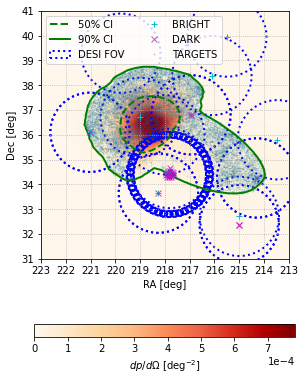

In [51]:
# *************************************************************************
#
# PLOTTING RESULTS
#
# *************************************************************************

# Plot targetlist tile matches and DESI FOV, just in case 
#print("\n# of Tile RA's: ", len(targetlist_tile_ras))

# It makes more sense to use the boundaries of the CI level
# but using the targetlist tile coords can be a good litmus test
# if something doesn't look right
# plot_ra  = [max(ra_degraded),  min(ra_degraded)]
# #plot_ra  = [max(targetlist_tile_ras), min(targetlist_tile_ras)]
# plot_ra_lim  = plot_ra[0] + 4, plot_ra[1] - 3

# plot_dec = [min(dec_degraded), max(dec_degraded)]
# #plot_dec = [max(targetlist_tile_decs), min(targetlist_tile_decs)]
# plot_dec_lim  = plot_dec[0] - 3, plot_dec[1] + 3

#print("tile_ra, tile_dec")
#print(*list(zip(plot_ra, plot_dec)), sep = "\n")

fig = plot_cartmap_tiles(gwfile, 
                        # From func: Add DESI tile drawings, specified by central RA, Dec.
                         tile_ra = True, 
                         tile_dec = True,

                         # Everything else seems about right
                         targ_ra = targetlist_tile_ras[:40], 
                         targ_dec = targetlist_tile_decs[:40], 

                         angsize = 5, 
                         program_names = targetlist_program_info)
ax = fig.gca()

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ax.set(
       #xlim  = [xmax, xmin], 
       #ylim  = [ymin, ymax],
       # Confusingly, since the map is already defined high -> low
       # xmin is high, xmax is low
       xticks = np.arange(int(xmin), int(xmax) - 1, -1),  # noninclusive of end hence -1
       yticks = np.arange(int(ymin), int(ymax) + 1)
      )

target_str = "TARGETS"
ax.scatter(targlist_radec_reduced['RA'], 
           targlist_radec_reduced['DEC'], 
           alpha = 0.1, 
           s = 0.1, 
           label = target_str)

handles, labels = ax.get_legend_handles_labels()
l_h_dict = dict(zip(labels, handles))

l_h_dict[target_str] = mlines.Line2D([], [], color='darkgrey', marker='.', linestyle='None',
                                    markersize=1)

order = ["50% CI", "90% CI", "DESI FOV", "BRIGHT", "DARK", target_str]

ax.legend([l_h_dict[label] for label in order], order, fontsize=10, ncol=2)
#ax.scatter(targlist['RA'], targlist['DEC'])
plt.savefig(os.path.join(event_dir, f"{gw_name}_desi_tile-matches.png"), dpi=120)

In [ ]:
# *************************************************************************
#
# DISRUPTIVE MODE
#
# *************************************************************************    

    # Use some sneaky Python-fu to determine number of pointings 
    # i.e. nd_mode as non-zero for bool evaluation and as integer
    
#     if nd_mode:
#         nd_tile_info = nondisruptive_mode(map_properties, degraded_map_properties, pixmap, num_pointings = nd_mode, restrict = False, overlap = True)
        
#         outfile = f'{gw_name}_ND_ToO_ledger.ecsv'
#         outfile = os.path.join(targetlists_path, outfile)
        
#         write_too_ledger(outfile, nd_tile_info.to_pandas(), 
#                          checker='MP/AP', overwrite=True, verbose=False, tabformat='ND')

if not nd_mode:
    outfile = disruptive_mode(gwfile_path = path_gwfile, gw_name = gw_name)
    os.replace(outfile, os.path.join(targetlists_path, os.path.basename(outfile)))


In [ ]:
# *************************************************************************
#
# TIDYING UP
#
# *************************************************************************
    
# Returning you back from whence you came!
os.chdir(original_dir)